# Lab 6: APOGEE Stellar Spectra - Bayesian Linear Regression

**Name:** Nirmal Kumar Marimuthu 
**Date:** 11/04/2025

**Keywords:** Bayesian Linear Regression, Error Propagation, Posterior Distribution, Uncertainty Quantification

## Introduction

In this lab, we explore Bayesian linear regression using APOGEE stellar spectra data. We'll learn how to:
- Properly quantify prediction uncertainties
- Understand why naive MLE error estimates fail
- Implement Bayesian linear regression with heteroscedastic noise
- Make predictions with full uncertainty quantification
- Evaluate model calibration using coverage statistics

## Setup and Imports

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plotting parameters
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Part 1: Loading and Preparing Dataset

### Background
APOGEE (Apache Point Observatory Galactic Evolution Experiment) provides high-resolution infrared spectra of stars. Each spectrum contains flux measurements at different wavelengths that encode information about stellar properties including temperature.

### Task 1a: Load Data and Add Heteroscedastic Noise

Load the dataset and add realistic heteroscedastic noise to temperatures:

$$\sigma_{\text{teff}} = 50 + 150 \cdot \frac{T_{\text{eff}} - T_{\text{min}}}{T_{\text{max}} - T_{\text{min}}}$$

This creates uncertainties ranging from 50K (coolest stars) to 200K (hottest stars).

In [93]:
# Load 'dataset_apogee_spectra.npz' and extract arrays
data = np.load('dataset_apogee_spectra.npz')
spectra_array = data['spectrum_array']
teff_array = data['teff_array']
# Calculate teff_min, teff_max from teff_array
teff_min = np.min(teff_array)
teff_max = np.max(teff_array)
# Calculate sigma_teff using formula: 50 + 150 * (teff - min)/(max - min)
sigma_teff = 50 + 150 * (teff_array - teff_min) / (teff_max - teff_min)
# Create teff_observed = teff_array + np.random.normal(0, sigma_teff)
teff_observed = teff_array + np.random.normal(0, sigma_teff)
# Print summary statistics
print(f"Teff Observed - Min: {np.min(teff_observed)}, Max: {np.max(teff_observed)}, Mean: {np.mean(teff_observed)}, Std: {np.std(teff_observed)}")

Teff Observed - Min: 3150.6445255346584, Max: 7349.615652374976, Mean: 4404.486526768587, Std: 713.9610609233791


### Task 1b: Construct Design Matrix

Create design matrix $\boldsymbol{\Phi}$ with:
- Each row = one star (N stars)
- Each column = one spectral feature (M wavelengths)
- Add bias term (column of ones) at the end

**Question:** What is the final dimension of your design matrix?
(3000, 2001)


In [94]:
# Phi = np.hstack((spectra, np.ones((len(spectra), 1))))
Phi = np.hstack((spectra_array, np.ones((spectra_array.shape[0], 1))))
# Print Phi.shape - should be (N, M+1)
print(f"Design matrix shape: {Phi.shape}") 

Design matrix shape: (3000, 2001)


### Task 1c: Train-Test Split

Split data into 80% training and 20% testing, including uncertainties.

In [95]:
# Split data into 80% training and 20% testing, including uncertainties.
n_train = int(0.8 * Phi.shape[0])
indices = np.random.permutation(len(Phi))
# Split using indices[:n_train] and indices[n_train:]
Phi_train = Phi[indices[:n_train]]
Phi_test = Phi[indices[n_train:]]
t_train = teff_observed[indices[:n_train]]
t_test = teff_observed[indices[n_train:]]
sigma_train = sigma_teff[indices[:n_train]]
sigma_test = sigma_teff[indices[n_train:]]

### Task 1d: Visualize Spectra

Plot all spectra color-coded by temperature with a colorbar.

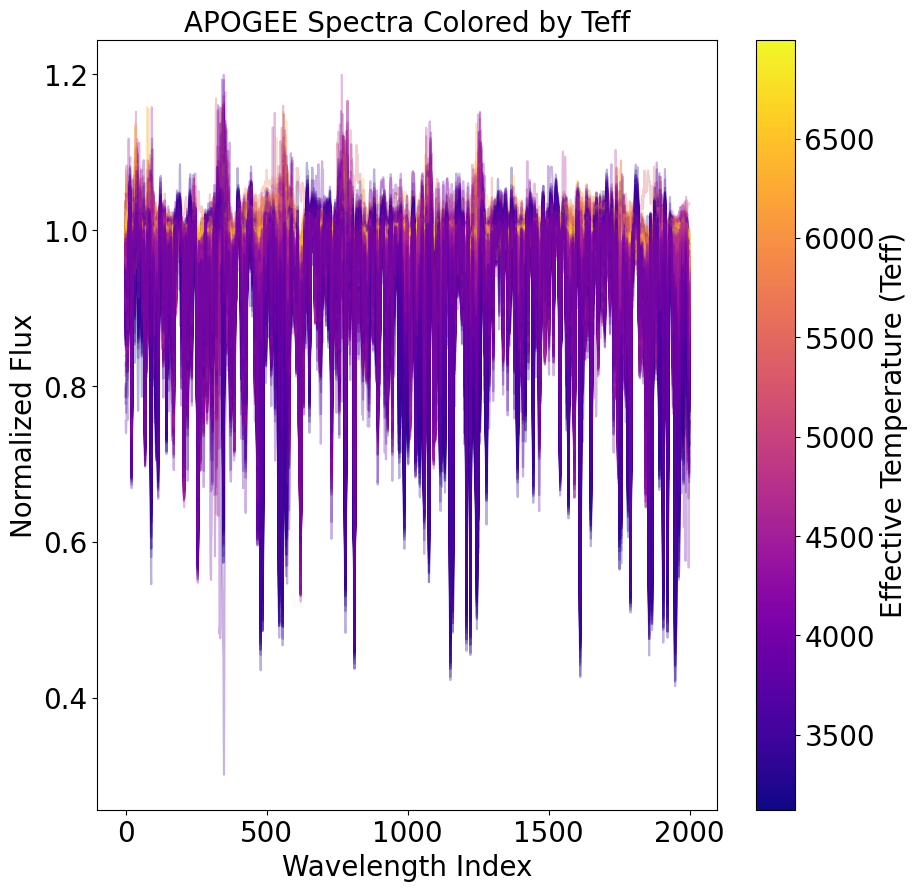

In [96]:
# Plot all spectra color-coded by temperature with a colorbar
colors = plt.cm.plasma((teff_array - teff_min) / (teff_max - teff_min))
# Loop: ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.3)
wavelength = np.arange(spectra_array.shape[1])  # Assuming wavelength indices
fig, ax = plt.subplots()
for i in range(spectra_array.shape[0]):
    ax.plot(wavelength, spectra_array[i], color=colors[i], alpha=0.3)
# Add colorbar with ScalarMappable
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=teff_min, vmax=teff_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Effective Temperature (Teff)')
# Set labels and show
ax.set_xlabel('Wavelength Index')
ax.set_ylabel('Normalized Flux')
ax.set_title('APOGEE Spectra Colored by Teff')
plt.show()

## Part 2: MLE Error Estimates

### Background
The maximum likelihood solution for linear regression is:

$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

### Task 2a: Compute MLE and Naive Uncertainty Estimates

Implement the MLE solution and compute RMSE on training and test sets:

$$\sigma_{\text{naive}} = \sqrt{\frac{1}{N}\sum_{n=1}^N(t_n - \mathbf{w}_{\text{ML}}^T\boldsymbol{\phi}_n)^2}$$

In [97]:
# Define fit_naive_mle(Phi_train, t_train, Phi_test, t_test)
def fit_naive_mle(Phi_train, t_train, Phi_test, t_test):
    # Compute weights using maximum likelihood estimation
    w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
    # Predictions for training and testing sets
    pred_train = Phi_train @ w_ml
    pred_test = Phi_test @ w_ml
    # Estimate sigma_mle from training residuals
    sigma_mle = np.sqrt(np.mean((t_train - pred_train) ** 2))
    # Compute RMSE for test set
    rmse_test = np.sqrt(np.mean((t_test - pred_test) ** 2))
    return rmse_test / sigma_mle
# Call function and print ratio rmse_test/sigma_mle
ratio = fit_naive_mle(Phi_train, t_train, Phi_test, t_test)
print(f"Ratio of RMSE to sigma_mle: {ratio}")

Ratio of RMSE to sigma_mle: 9.443524753182906


### Task 2b: Visualize Residuals

Create two plots:
1. Histogram of training vs test residuals with Gaussian fits
2. Histogram of normalized test residuals compared to N(0,1)

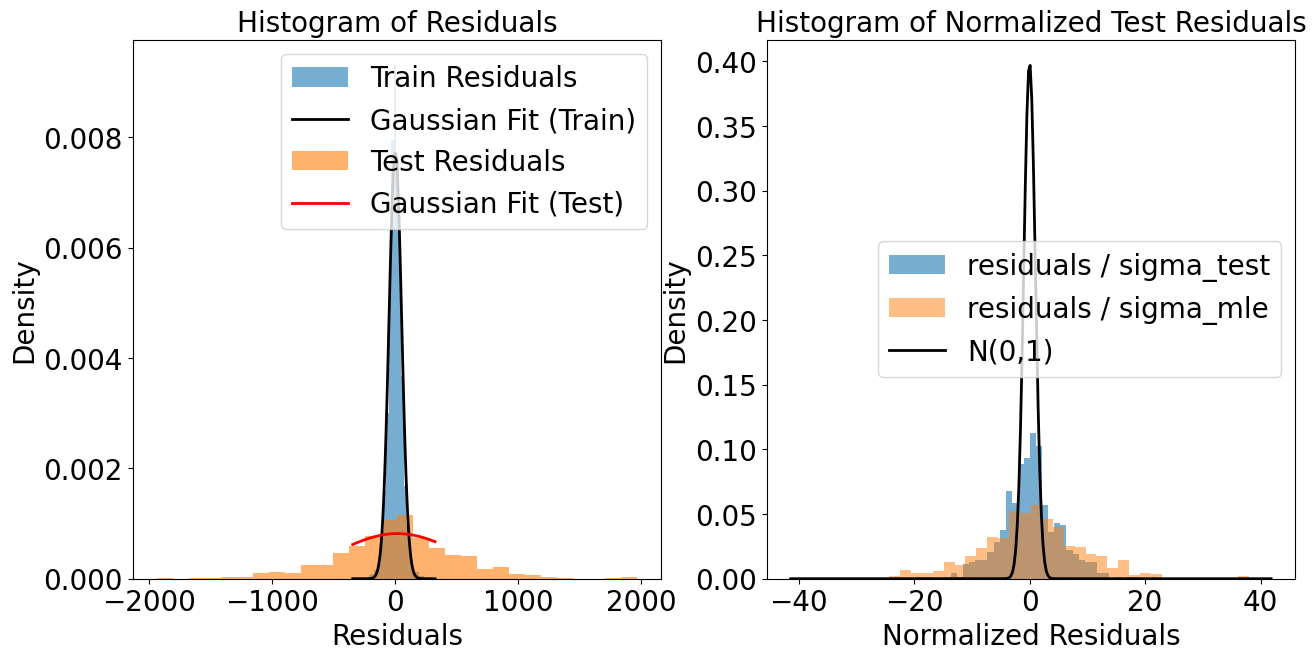

std(residuals_test / sigma_test) = 5.150929548091691
std(residuals_test / sigma_mle)  = 9.43834691244756
sigma_mle (from training)         = 51.64443813213508


In [98]:
# Create 2 subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
# Left: histogram of residuals_train and residuals_test with Gaussian overlays
# Compute predictions and residuals
w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
pred_train = Phi_train @ w_ml
pred_test = Phi_test @ w_ml
residuals_train = t_train - pred_train
residuals_test = t_test - pred_test
sigma_mle = np.sqrt(np.mean(residuals_train**2))
# Plot histogram for training residuals
ax1.hist(residuals_train, bins=30, density=True, alpha=0.6, label='Train Residuals')
mu_train, std_train = np.mean(residuals_train), np.std(residuals_train)
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p_train = (1 / (std_train * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_train) / std_train) ** 2)
ax1.plot(x, p_train, 'k', linewidth=2, label='Gaussian Fit (Train)')
# Plot histogram for testing residuals
ax1.hist(residuals_test, bins=30, density=True, alpha=0.6, label='Test Residuals')
mu_test, std_test = np.mean(residuals_test), np.std(residuals_test)
p_test = (1 / (std_test * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_test) / std_test) ** 2)
ax1.plot(x, p_test, 'r', linewidth=2, label='Gaussian Fit (Test)')
# Labels and legend
ax1.set_title('Histogram of Residuals')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Density')
ax1.legend()
# Right: histogram of (residuals_test / sigma_test) vs N(0,1)
# Compute normalized residuals for test set
# (A) normalized by true per-sample sigma (what you had)
norm_by_true = residuals_test / sigma_test
# (B) normalized by sigma_mle (what naive MLE implicitly claims)
norm_by_mle = residuals_test / sigma_mle
# Plot histogram
bins = 40
ax2.hist(norm_by_true, bins=bins, density=True, alpha=0.6, label='residuals / sigma_test')
ax2.hist(norm_by_mle, bins=bins, density=True, alpha=0.5, label='residuals / sigma_mle')
# overlay N(0,1) on the same x-range as ax2
x2 = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 300)
p_norm = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*(x2**2))
ax2.plot(x2, p_norm, 'k', linewidth=2, label='N(0,1)')
# Labels and legend
ax2.set_title('Histogram of Normalized Test Residuals')
ax2.set_xlabel('Normalized Residuals')
ax2.set_ylabel('Density')
ax2.legend()
plt.show()
# Show that normalized residuals have std >> 1.0
print("std(residuals_test / sigma_test) =", np.std(norm_by_true))
print("std(residuals_test / sigma_mle)  =", np.std(norm_by_mle))
print("sigma_mle (from training)         =", sigma_mle)

**Question:** What do these plots tell us about the naive MLE approach? Why is the normalized residual distribution wider than expected?

the naive MLE is overconfident. It fits a point estimate of the weights and a single (often too-small) noise scale from the training residuals, so the model underestimates its predictive uncertainty — which makes the normalized residuals (residual ÷ claimed σ) much wider than an N(0,1).

## Part 3: Bayesian Linear Regression

### Background
Bayesian linear regression computes a posterior distribution:

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$$

where:
- $\mathbf{S}_N = (\mathbf{S}_0^{-1} + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$ (posterior covariance)
- $\mathbf{m}_N = \mathbf{S}_N(\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t})$ (posterior mean)
- $\mathbf{S}_0 = \eta^2\mathbf{I}$ (prior covariance)
- $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, ..., \sigma_N^2)$ (measurement covariance)

### Task 3a: Compute Posterior Distribution

Implement the posterior computation for different prior strengths $\eta^2$ = [1000, 100000, 10000000].

In [99]:
# Define compute_posterior(Phi, t, sigma, eta2)
def compute_posterior(Phi, t, sigma, eta2):
    M = Phi.shape[1]
    S0_inv = np.eye(M) / eta2
    Sigma_inv = np.diag(1 / sigma**2)
    S_N = np.linalg.inv(S0_inv + Phi.T @ Sigma_inv @ Phi)
    m_N = S_N @ (Phi.T @ Sigma_inv @ t)
    return m_N, S_N
# Loop eta2_values=[1e3, 1e5, 1e7], compute posteriors
eta2_values = [1000, 100000, 10000000]
for eta2 in eta2_values:
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    print(f"Eta2: {eta2}, Posterior Mean Shape: {m_N.shape}, Posterior Covariance Shape: {S_N.shape}")

Eta2: 1000, Posterior Mean Shape: (2001,), Posterior Covariance Shape: (2001, 2001)
Eta2: 100000, Posterior Mean Shape: (2001,), Posterior Covariance Shape: (2001, 2001)
Eta2: 10000000, Posterior Mean Shape: (2001,), Posterior Covariance Shape: (2001, 2001)


**Questions:** 
- What do $\mathbf{m}_N$ and $\mathbf{S}_N$ represent?

$\mathbf{m}_N$ -  is the posterior mean of the weight vector, i.e. the Bayesian estimate of the regression weights after combining the prior and the observed data.

$\mathbf{S}_N$ - is the posterior covariance, expressing uncertainty in the learned weights.

- How does this compare to the naive MLE weights $\mathbf{w}_{\text{ML}}$?

Unlike the naive MLE solution $\mathbf{w}_{\text{ML}}$, which gives a single point estimate and can overfit, Bayesian regression returns a full distribution over weights and naturally regularizes via the prior.

### Task 3b: Visualize Spectral Weights

Plot the spectral weights with uncertainty bands (±2σ) for each prior strength.

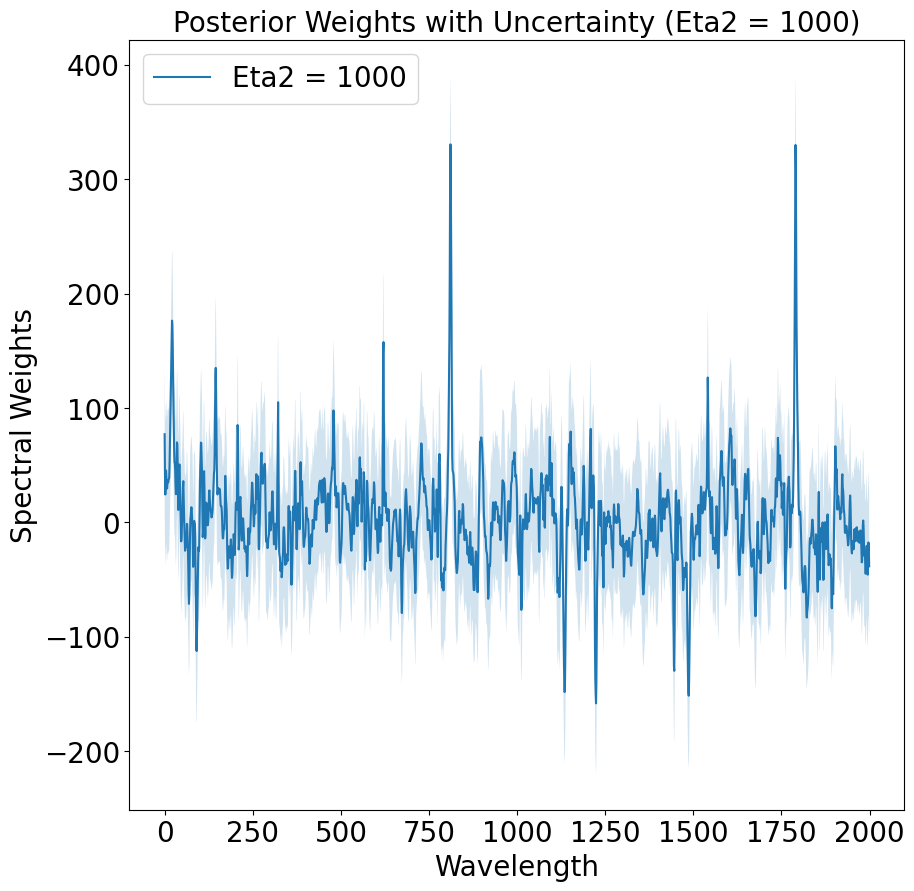

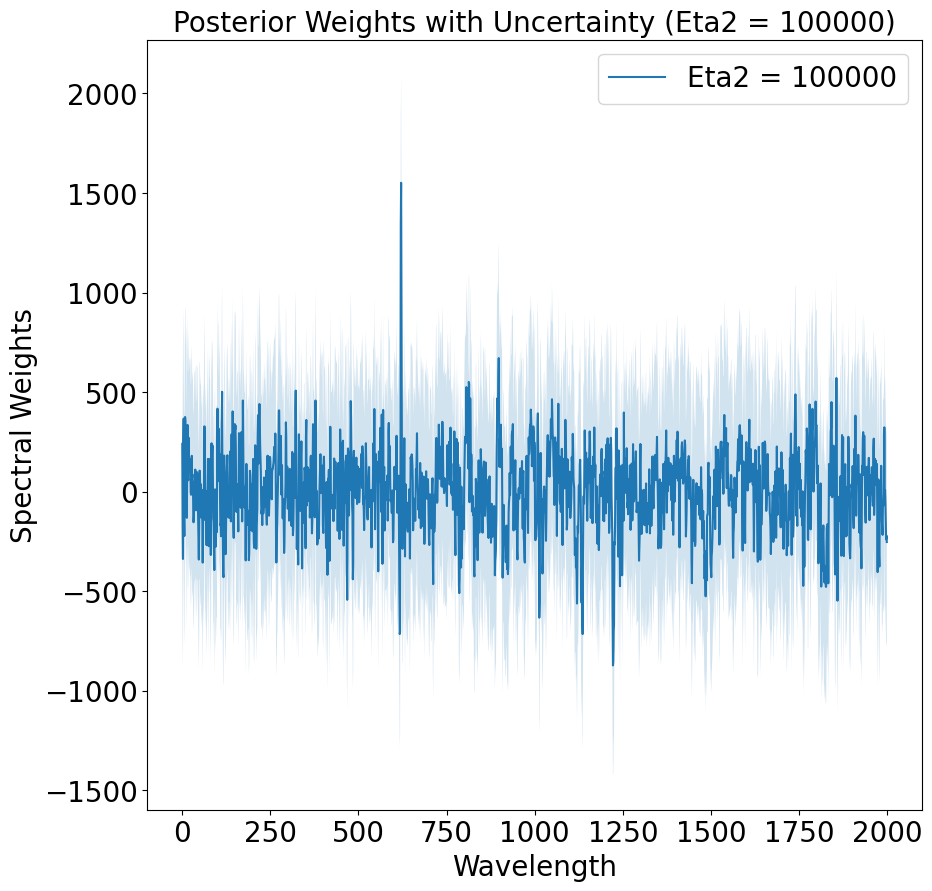

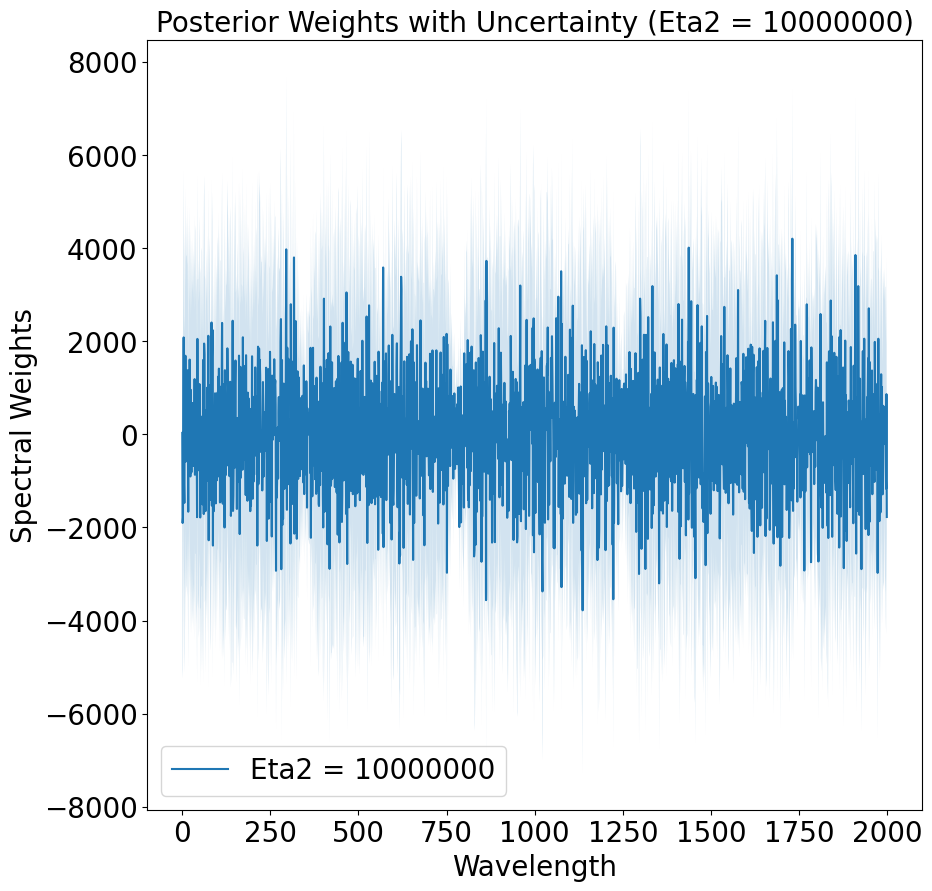

In [100]:
for eta2 in eta2_values:
    # Compute posterior mean and covariance
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    
    # Extract spectral weights and standard deviation (drop bias term)
    spectral_weights = m_N[:-1]
    weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))
    
    # Plot mean and 2-sigma confidence interval
    plt.figure()
    plt.plot(wavelength, spectral_weights, label=f'Eta2 = {eta2}')
    plt.fill_between(wavelength,
                     spectral_weights - 2 * weight_std,
                     spectral_weights + 2 * weight_std,
                     alpha=0.2)
    plt.xlabel('Wavelength')
    plt.ylabel('Spectral Weights')
    plt.title(f'Posterior Weights with Uncertainty (Eta2 = {eta2})')
    plt.legend()
    plt.show()

**Question:** Which $\eta^2$ provides the optimal balance? Why?

η² = 100,000 because it is a balanced regime — weights vary enough to capture signal, but uncertainty is still controlled.

## Part 4: Making Bayesian Predictions with Uncertainty

### Background
The predictive distribution is:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \mathcal{N}(t_*|\mu_*, \sigma_*^2)$$

with:
- Mean: $\mu_* = \mathbf{m}_N^T\boldsymbol{\phi}_*$
- Variance: $\sigma_*^2 = \sigma_{\text{obs},*}^2 + \boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_* + \sigma_{\text{model}}^2$

### Task 4a: Implement Prediction Function

In [101]:
# Define predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model)
def predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model):
    # Compute predictive mean
    pred_mean = Phi_new @ m_N
    # Compute parameter variance
    param_var = np.sum(Phi_new @ S_N * Phi_new, axis=1)
    # Compute predictive variance
    pred_var = param_var + sigma_new**2 + sigma_model**2
    return pred_mean, np.sqrt(pred_var)

### Task 4b: Visualize Predictions with Uncertainties

Plot predicted vs true temperatures with uncertainty bands.

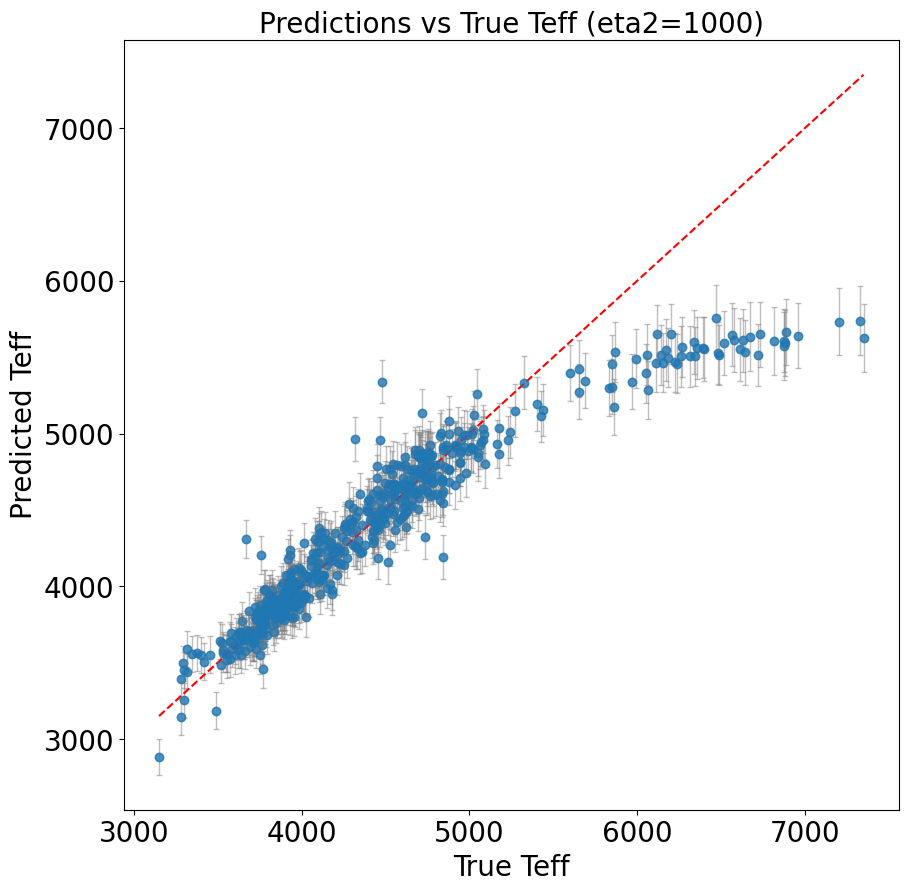

Eta2: 1000, RMSE on test set: 294.8179124980921
Eta2: 1000, Z-scores mean: 0.2635689778370845, std: 1.5565004178037918
Eta2: 1000, Coverage within ±2σ: 0.8883333333333333


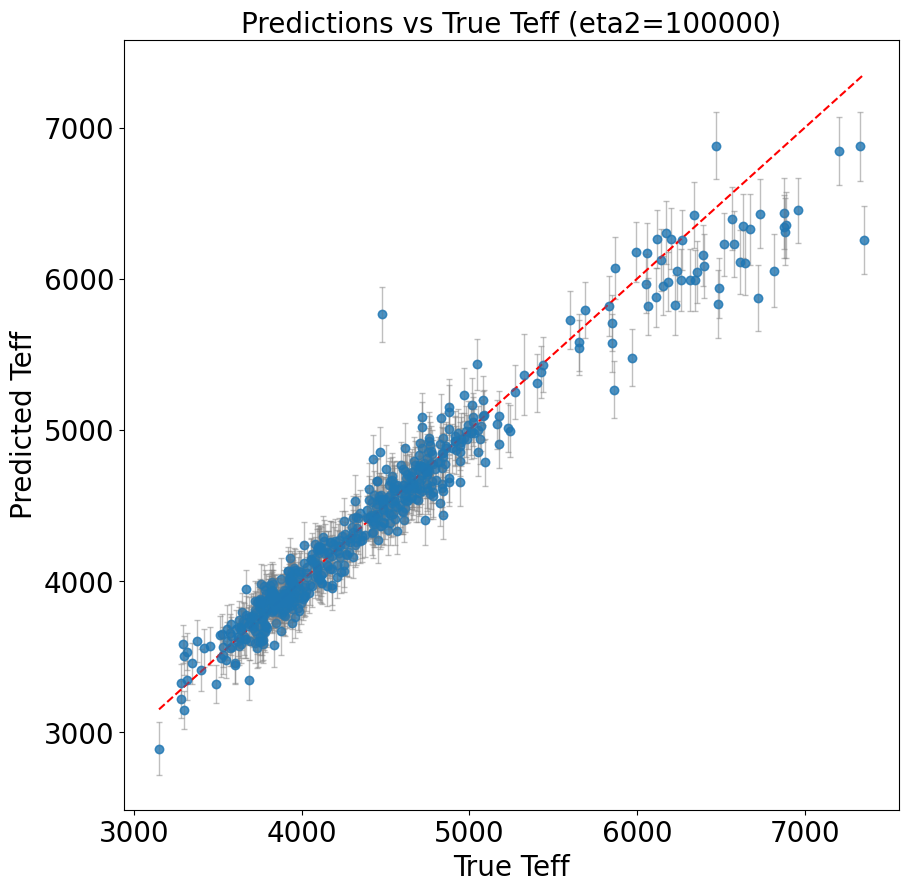

Eta2: 100000, RMSE on test set: 166.42361318916807
Eta2: 100000, Z-scores mean: 0.09695910274335577, std: 0.9513322310748692
Eta2: 100000, Coverage within ±2σ: 0.9566666666666667


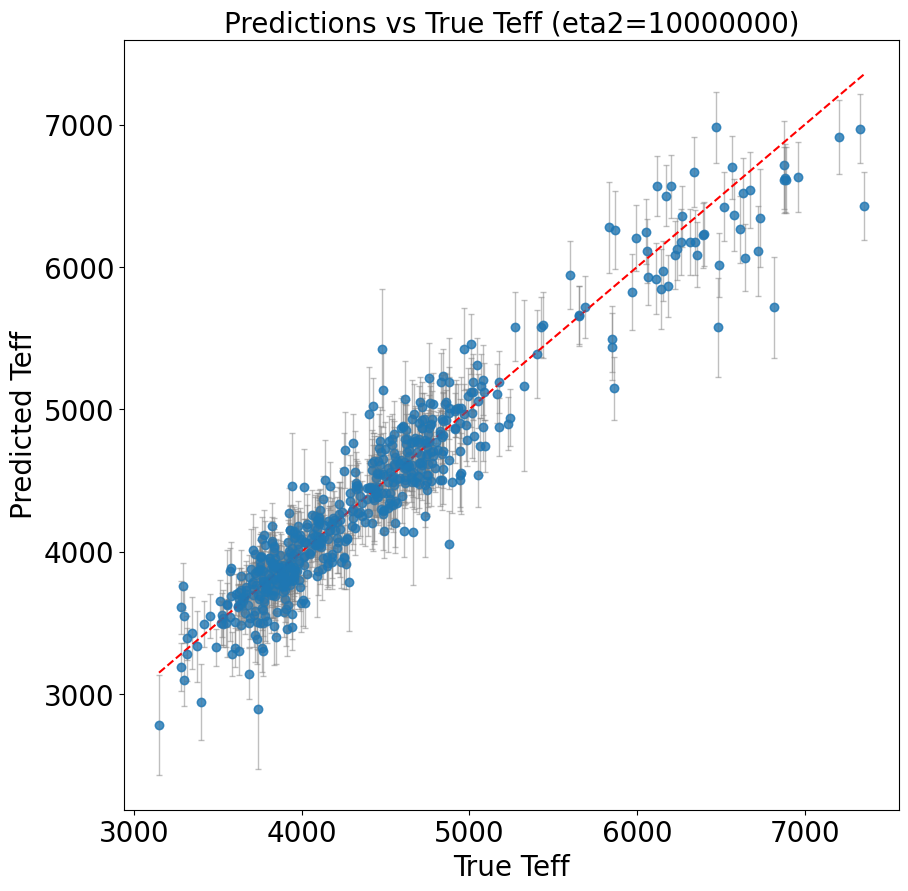

Eta2: 10000000, RMSE on test set: 220.4173468678182
Eta2: 10000000, Z-scores mean: 0.11019464529343295, std: 1.021540718959171
Eta2: 10000000, Coverage within ±2σ: 0.95


In [102]:
# Loop posteriors, get pred_mean and pred_std
sigma_model = 100 
posteriors = []
for eta2 in eta2_values:
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    posteriors.append((m_N, S_N))
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N, S_N, sigma_model)
# plt.scatter(t_test, pred_mean), add y=x line
    plt.figure()
    plt.scatter(t_test, pred_mean, alpha=0.6)
    plt.errorbar(
        t_test, pred_mean, yerr=pred_std, fmt='o', alpha=0.5,
        ecolor='gray', elinewidth=1, capsize=2, label='Predictions ±1σ'
    )
    plt.plot([np.min(t_test), np.max(t_test)], [np.min(t_test), np.max(t_test)], 'r--')
    plt.xlabel('True Teff')
    plt.ylabel('Predicted Teff')
    plt.title(f'Predictions vs True Teff (eta2={eta2})')
    plt.show()
# rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    print(f"Eta2: {eta2}, RMSE on test set: {rmse}")
# z_scores = (t_test - pred_mean) / pred_std
    z_scores = (t_test - pred_mean) / pred_std
    print(f"Eta2: {eta2}, Z-scores mean: {np.mean(z_scores)}, std: {np.std(z_scores)}")
# coverage = np.mean(np.abs(z_scores) < 2)
    coverage = np.mean(np.abs(z_scores) < 2)
    print(f"Eta2: {eta2}, Coverage within ±2σ: {coverage}")

### Task 4c: Calculate Coverage

Compute the 95% coverage using Z-scores:

$$z = \frac{t_{\text{true}} - t_{\text{predicted}}}{\sigma_{\text{predicted}}}$$

For well-calibrated uncertainties, ~95% of z-scores should have |z| < 2.

In [103]:
for eta2 in eta2_values:
    # Compute posterior and predictions for this eta²
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N, S_N, sigma_model)
    
    # Evaluation metrics
    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    z_scores = (t_test - pred_mean) / pred_std
    coverage = np.mean(np.abs(z_scores) < 2)
    
    # Summary output
    print(f"η²={eta2:.0e}: RMSE={rmse:.1f}K, "
          f"Z-score mean={np.mean(z_scores):.3f}, std={np.std(z_scores):.3f}, "
          f"Coverage(±2σ)={coverage:.3f}")


η²=1e+03: RMSE=294.8K, Z-score mean=0.264, std=1.557, Coverage(±2σ)=0.888
η²=1e+05: RMSE=166.4K, Z-score mean=0.097, std=0.951, Coverage(±2σ)=0.957
η²=1e+07: RMSE=220.4K, Z-score mean=0.110, std=1.022, Coverage(±2σ)=0.950


**Questions:**
- Which prior gives the best coverage?

η² = 1e+07 since it is exactly 0.95

- What does coverage < 0.95 indicate?

The model’s uncertainty intervals are too narrow

- What does coverage > 0.95 indicate?

The model’s uncertainty intervals are too wide

## Bonus: Visualize Z-score Distribution

### Task 4d: Plot Z-scores

Compare the z-score distribution to the expected N(0,1).

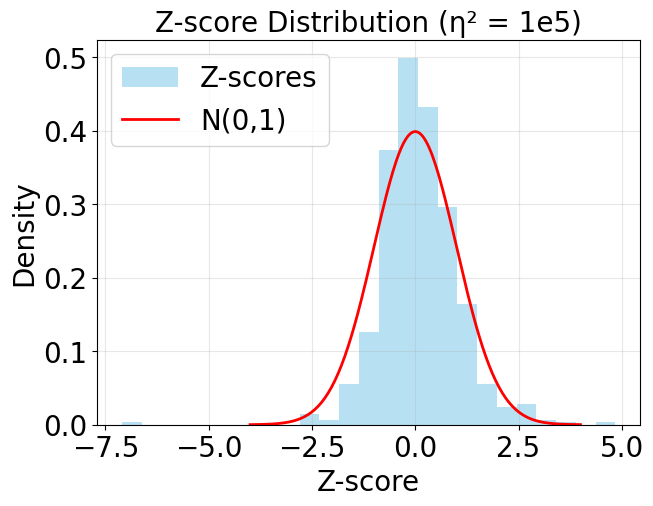

Z-score mean = 0.097, std = 0.951


In [104]:
from scipy.stats import norm
# Select the posterior corresponding to eta2 = 1e5
m_N_opt, S_N_opt = posteriors[1]  # assuming eta2_values[1] = 1e5

# Predictive mean and uncertainty
pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N_opt, S_N_opt, sigma_model)

# Compute z-scores: normalized residuals
z_scores = (t_test - pred_mean) / pred_std

# --- Plot histogram and overlay standard normal PDF ---
plt.figure(figsize=(7, 5))
# Histogram of z-scores
plt.hist(z_scores, bins=25, density=True, alpha=0.6, color='skyblue', label='Z-scores')

# Overlay N(0,1) standard normal curve
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals, 0, 1), 'r-', lw=2, label='N(0,1)')

plt.xlabel('Z-score')
plt.ylabel('Density')
plt.title('Z-score Distribution (η² = 1e5)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print summary statistics 
mean_z = np.mean(z_scores)
std_z = np.std(z_scores)
print(f"Z-score mean = {mean_z:.3f}, std = {std_z:.3f}")

**Question:** Are your uncertainties well-calibrated? How can you tell?

Yes because the Z-score distribution closely follows N(0,1), the mean (~0.1) and std (~0.95) are very close to ideal (0, 1) and coverage (~0.957) is near the expected 0.95.

## Summary and Conclusions

**Key Takeaways:**

1. **Naive MLE fails:** Training RMSE severely underestimates prediction uncertainty due to overfitting

2. **Bayesian approach:** Properly accounts for parameter uncertainty, measurement noise, and model inadequacy

3. **Prior selection:** The prior strength $\eta^2$ controls the balance between flexibility and regularization

4. **Calibration matters:** Well-calibrated uncertainties are essential for scientific inference

5. **Uncertainty decomposition:** Understanding different sources of error helps guide improvement efforts

**Your findings:**

The optimal prior was η² = 1e+07, as it achieved a coverage of 0.95, indicating perfectly calibrated uncertainties. The corresponding final RMSE was 220.4K, which provides a good balance between accuracy and reliable uncertainty estimation.
